### Universidade do Vale do Itajaí - UNIVALI

#### Processamento de Imagens - Professor Felipe Viel

**Alunos**: Daniel Sansão Araldi, Rafael Mota Alves, Kauan Guerreiro Adami Chaves

Instalando **MedMNIST**

In [2]:
%pip install medmnist

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Importantando MedMNIST, Numpy, tqdm e torch.

In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

Trabalhando com imagens de tamanho 128x128.

In [4]:
data_flag = 'pathmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Lendo os dados do MedMNIST, preprocessando eles e encapsulando eles dentro de um `DataLoader`.

In [48]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=128)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 4.26G/4.26G [07:58<00:00, 8.89MB/s] 


In [7]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

Imagens do trabalho.

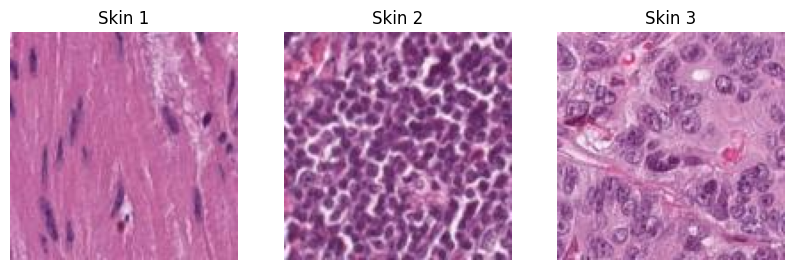

In [21]:
image_skin1 = cv2.imread('../images/skin-1.png')
image_skin2 = cv2.imread('../images/skin-2.png')
image_skin3 = cv2.imread('../images/skin-3.png')

image_skin1 = cv2.cvtColor(image_skin1, cv2.COLOR_BGR2RGB)
image_skin2 = cv2.cvtColor(image_skin2, cv2.COLOR_BGR2RGB)
image_skin3 = cv2.cvtColor(image_skin3, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(image_skin1)
plt.title("Skin 1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_skin2)
plt.title("Skin 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_skin3)
plt.title("Skin 3")
plt.axis('off')

plt.show()

O MSE é uma técnica utilizada para identificar distorções espaciais (estruturas - simetria) da imagem após processamento. Quanto mais próximo do zero, mais iguais as imagens são.


In [12]:
def mse(imageA, imageB):
  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
  err /= float(imageA.shape[0] * imageA.shape[1])

  return err

O RMSE é o MSE com a aplicação de uma raiz quadrada. Indica o erro padronizado e é geralmente geralmente mais utilizado que o MSE - quanto maior pior.

In [13]:
def rmse(imageA, imageB):
  return np.sqrt(mse(imageA, imageB))

PSNR é a razão entre a potência máxima de um sinal e a potência máxima do sinal do ruído.

1. Medido em dB.
2. Quanto maior melhor (considerável bom >= `20` dB).
3. L indica o valor máximo do pixel (ex: `255`).

In [14]:
def psnr(original, compressed):
  mse = np.mean((original - compressed) ** 2)
  if mse == 0:
    return 100

  max_pixels = 255
  return 20 * np.log10(max_pixels / np.sqrt(mse))

O SSIM é uma métrica baseada em recurso do Sistema Visual Humano (HVS) – Hue, Saturation or Intensity Value.

– O SSIM mede a semelhança entre duas imagens, sendo uma melhoria em relação a métodos como MSE e PSNR.

- Basicamente, calcula a degradação da imagem para algum processo.

– Vai de `-1` a `1`, sendo `1` para imagens idênticas.

In [15]:
%pip install SSIM-PIL

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from SSIM_PIL import compare_ssim
from PIL import Image

In [17]:
def ssim(imageA, imageB):
  imageAArray = Image.fromarray(imageA)
  imageBArray = Image.fromarray(imageB)

  return compare_ssim(imageAArray, imageBArray, GPU=False)

O GMSD, assim como SSIM, é uma métrica para o HSV.

- Avalia a distorção causada pelo processamento entre a imagem de referência e a imagem processada.
- Os m’s referem-se as imagens e `c` é uma constante > `0`.
- Quanto maior o valor melhor a qualidade.

In [18]:
%pip install sporco

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import sporco.metric as sm

In [20]:
def gmsd(original, processed):
  return sm.gmsd(original, processed)

Filtro que permite deixar a imagem com cinza ponderado.

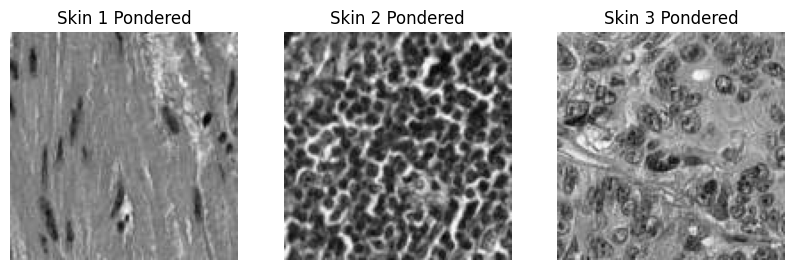

In [22]:
def grayscale_pondered(image):
  B, G, R = cv2.split(image)
  img_grayscale_pondered = 0.299 * B + 0.587 * G + 0.114 * R

  return np.array(img_grayscale_pondered, dtype=np.uint8)

image_skin1_pondered = grayscale_pondered(image_skin1)
image_skin2_pondered = grayscale_pondered(image_skin2)
image_skin3_pondered = grayscale_pondered(image_skin3)

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(image_skin1_pondered, cmap='gray')
plt.title("Skin 1 Pondered")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_skin2_pondered, cmap='gray')
plt.title("Skin 2 Pondered")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_skin3_pondered, cmap='gray')
plt.title("Skin 3 Pondered")
plt.axis('off')

plt.show()

Filtro que permite deixar a imagem com cinza básico (soma das cores divido por três).

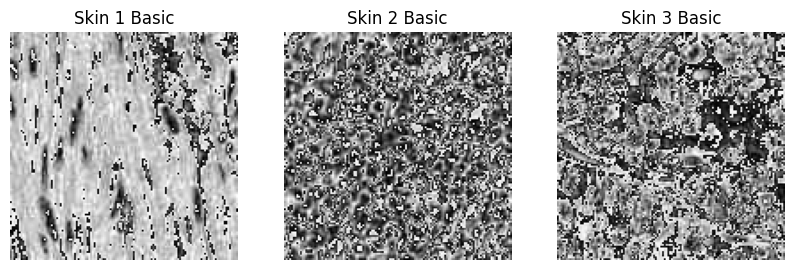

In [23]:
def grayscale_basic(image):
  B, G, R = cv2.split(image)
  img_grayscale_basic = (B+G+R)/3

  return np.array(img_grayscale_basic, dtype=np.uint8)

image_skin1_basic = grayscale_basic(image_skin1)
image_skin2_basic = grayscale_basic(image_skin2)
image_skin3_basic = grayscale_basic(image_skin3)

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(image_skin1_basic, cmap='gray')
plt.title("Skin 1 Basic")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_skin2_basic, cmap='gray')
plt.title("Skin 2 Basic")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_skin3_basic, cmap='gray')
plt.title("Skin 3 Basic")
plt.axis('off')

plt.show()

Adiciona `padding` a imagem.

In [24]:
def add_padding(img, padding_height, padding_width):
    n, m = img.shape

    padded_img = np.zeros((n + padding_height * 2, m + padding_width * 2))
    padded_img[padding_height : n + padding_height, padding_width : m + padding_width] = img

    return padded_img

Realiza a convolação da imagem.

In [26]:
def conv2d(img, kernel, padding=True):
    # Get dimensions of the kernel
    k_height, k_width = kernel.shape

    # Get dimensions of the image
    img_height, img_width = img.shape

    # Calculate padding required
    pad_height = k_height // 2
    pad_width = k_width // 2

    # Create a padded version of the image to handle edges
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)

    # Perform convolution
    for i_img in range(img_height):
        for j_img in range(img_width):
            for i_kernel in range(k_height):
                for j_kernel in range(k_width):
                    output[i_img, j_img] = output[i_img, j_img] + (padded_img[i_img+i_kernel, j_img+j_kernel] * kernel[i_kernel, j_kernel])
            output[i_img, j_img] = int(output[i_img, j_img])

    return np.clip(output, 0, 255).astype(np.uint8)

Filtro Laplaciano

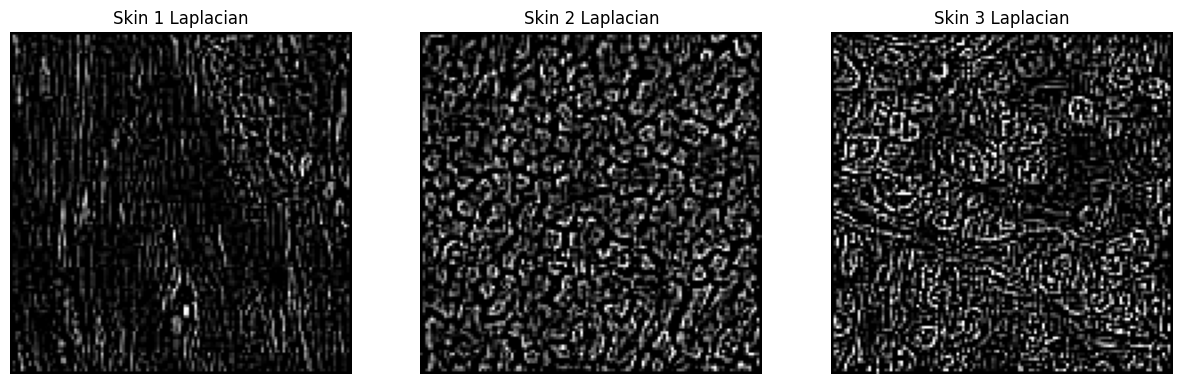

In [28]:
laplacian_kernel = np.array([[1, 1, 1],
                             [1, -8, 1],
                             [1, 1, 1]])

def laplacian(image, kernel):
    return conv2d(image, kernel)

image_skin1_laplacian = laplacian(image_skin1_pondered, laplacian_kernel)
image_skin2_laplacian = laplacian(image_skin2_pondered, laplacian_kernel)
image_skin3_laplacian = laplacian(image_skin3_pondered, laplacian_kernel)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_skin1_laplacian, cmap='gray')
plt.title("Skin 1 Laplacian")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_skin2_laplacian, cmap='gray')
plt.title("Skin 2 Laplacian")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_skin3_laplacian, cmap='gray')
plt.title("Skin 3 Laplacian")
plt.axis('off')

plt.show()

Filtro de Gaussiano

In [29]:
def gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

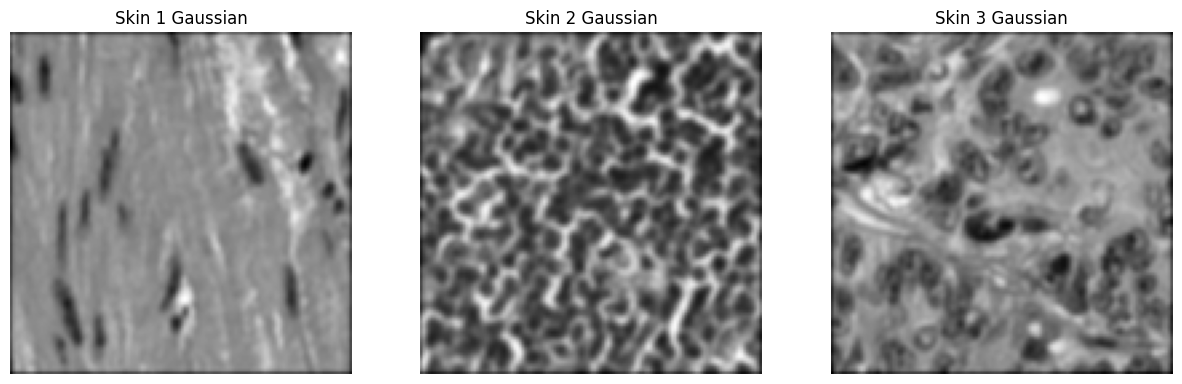

In [31]:
def gaussian(img, kernel):
    height, width = img.shape
    k_size = kernel.shape[0]
    pad = k_size // 2

    padded_img = add_padding(img, pad, pad)
    smoothed_img = np.zeros_like(img, dtype=float)

    for i in range(height):
        for j in range(width):
            region = padded_img[i:i+k_size, j:j+k_size]
            smoothed_img[i, j] = np.sum(region * kernel)

    return np.clip(smoothed_img, 0, 255).astype(np.uint8)

kernel = gaussian_kernel(size=5)
image_skin1_gaussian = gaussian(image_skin1_pondered, kernel)
image_skin2_gaussian = gaussian(image_skin2_pondered, kernel)
image_skin3_gaussian = gaussian(image_skin3_pondered, kernel)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_skin1_gaussian, cmap='gray')
plt.title("Skin 1 Gaussian")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_skin2_gaussian, cmap='gray')
plt.title("Skin 2 Gaussian")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_skin3_gaussian, cmap='gray')
plt.title("Skin 3 Gaussian")
plt.axis('off')

plt.show()

Filtro de Mediana

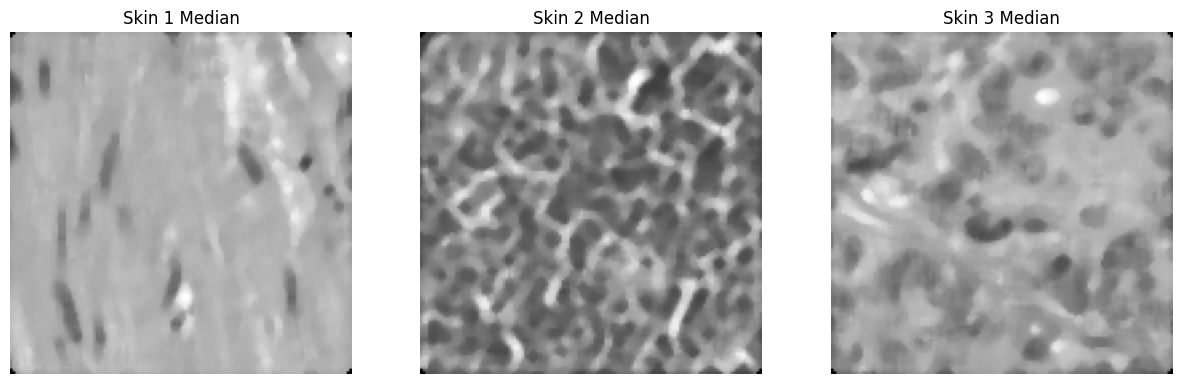

In [32]:
def median(image, kernel_size=5):
    pad_size = kernel_size // 2

    if len(image.shape) == 3:
        channels = cv2.split(image)
        filtered_channels = []
        for ch in channels:
            padded_ch = add_padding(ch, pad_size, pad_size)
            n, m = ch.shape
            output_ch = np.zeros_like(ch)
            for i in range(n):
                for j in range(m):
                    window = padded_ch[i:i+kernel_size, j:j+kernel_size]
                    output_ch[i, j] = np.median(window)
            filtered_channels.append(output_ch)
        output = cv2.merge(filtered_channels)
    else:
        padded_img = add_padding(image, pad_size, pad_size)
        n, m = image.shape
        output = np.zeros_like(image)
        for i in range(n):
            for j in range(m):
                window = padded_img[i:i+kernel_size, j:j+kernel_size]
                output[i, j] = np.median(window)
    return output

image_skin1_median = median(image_skin1_pondered)
image_skin2_median = median(image_skin2_pondered)
image_skin3_median = median(image_skin3_pondered)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_skin1_median, cmap='gray')
plt.title("Skin 1 Median")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_skin2_median, cmap='gray')
plt.title("Skin 2 Median")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_skin3_median, cmap='gray')
plt.title("Skin 3 Median")
plt.axis('off')

plt.show()

Filtro High-Boost Filtering

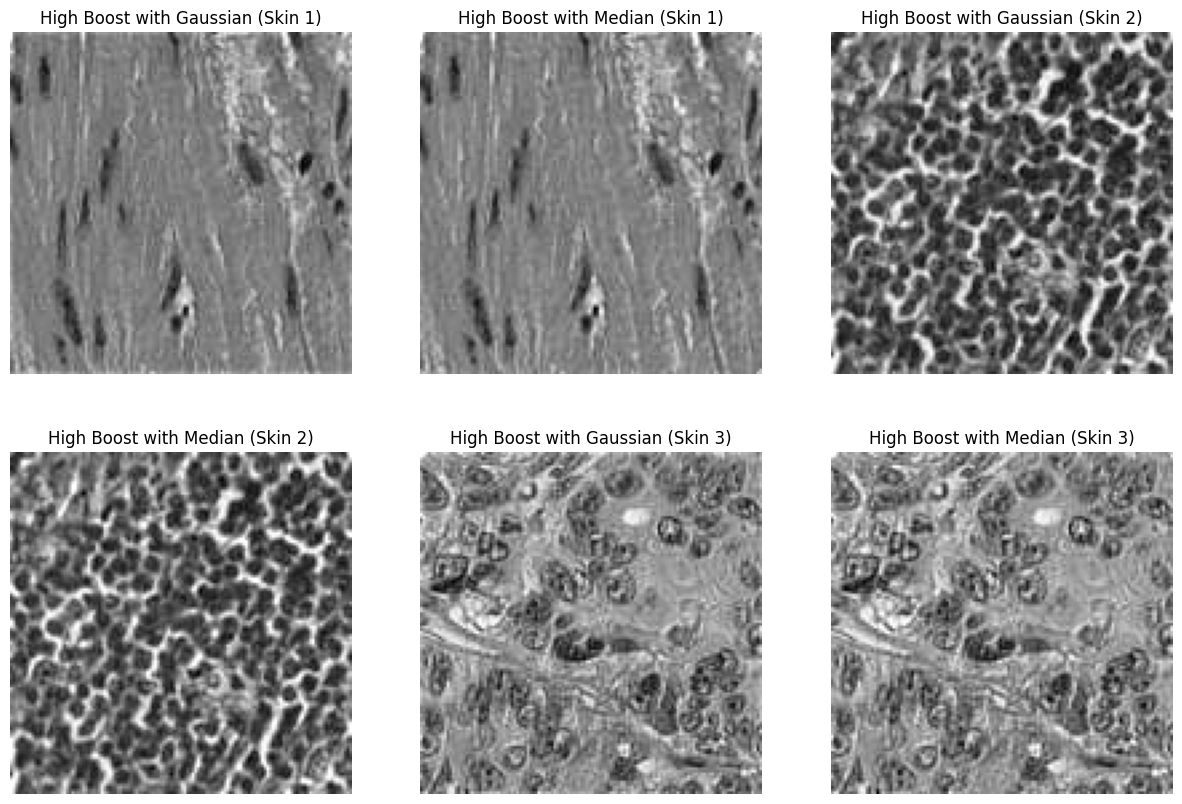

In [34]:
def high_boost(image, image_blurred):
    C = 1.5
    alpha = C
    beta = -(C - 1)
    gamma = 0

    result = alpha * image + beta * image_blurred + gamma

    return np.clip(result, 0, 255).astype(np.uint8)


image_high_boost_with_gaussian_skin1 = high_boost(image_skin1_pondered, image_skin1_gaussian)
image_high_boost_with_median_skin1 = high_boost(image_skin1_pondered, image_skin1_median)

image_high_boost_with_gaussian_skin2 = high_boost(image_skin2_pondered, image_skin2_gaussian)
image_high_boost_with_median_skin2 = high_boost(image_skin2_pondered, image_skin2_median)

image_high_boost_with_gaussian_skin3 = high_boost(image_skin3_pondered, image_skin3_gaussian)
image_high_boost_with_median_skin3 = high_boost(image_skin3_pondered, image_skin3_median)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(image_high_boost_with_gaussian_skin1, cmap='gray')
plt.title("High Boost with Gaussian (Skin 1)")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(image_high_boost_with_median_skin1, cmap='gray')
plt.title("High Boost with Median (Skin 1)")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(image_high_boost_with_gaussian_skin2, cmap='gray')
plt.title("High Boost with Gaussian (Skin 2)")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(image_high_boost_with_median_skin2, cmap='gray')
plt.title("High Boost with Median (Skin 2)")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(image_high_boost_with_gaussian_skin3, cmap='gray')
plt.title("High Boost with Gaussian (Skin 3)")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(image_high_boost_with_median_skin3, cmap='gray')
plt.title("High Boost with Median (Skin 3)")
plt.axis('off')

plt.show()

Filtro de Sobel

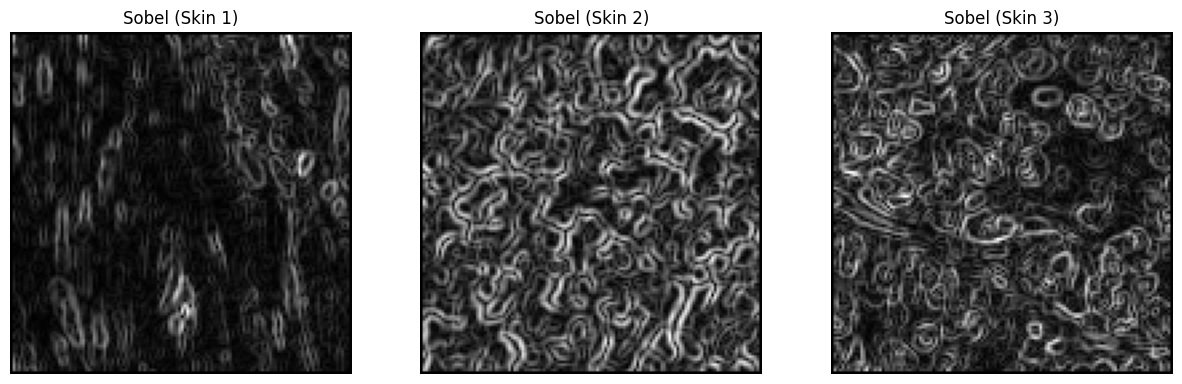

In [35]:
def normalize(img):
    img = np.abs(img)
    img = (img / img.max()) * 255
    return img.astype(np.uint8)

def sobel(image):
  # Convert to float64
  image = image.astype(np.float64)

  # Define Sobel kernels
  kernel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
  ])

  kernel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
  ])

  # Initialize output arrays
  height, width = image.shape
  sobel_x = np.zeros_like(image)
  sobel_y = np.zeros_like(image)

  # Apply convolution manually (ignoring borders)
  for i in range(1, height - 1):
      for j in range(1, width - 1):
          region = image[i - 1:i + 2, j - 1:j + 2]
          gx = np.sum(kernel_x * region)
          gy = np.sum(kernel_y * region)
          sobel_x[i, j] = gx
          sobel_y[i, j] = gy

  # Compute combined gradient magnitude
  sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)

  # Normalize all outputs to range [0, 255] and convert to uint8
  return normalize(sobel_combined)

image_skin1_sobel = sobel(image_skin1_pondered)
image_skin2_sobel = sobel(image_skin2_pondered)
image_skin3_sobel = sobel(image_skin3_pondered)

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(image_skin1_sobel, cmap='gray')
plt.title("Sobel (Skin 1)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_skin2_sobel, cmap='gray')
plt.title("Sobel (Skin 2)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_skin3_sobel, cmap='gray')
plt.title("Sobel (Skin 3)")
plt.axis('off')

plt.show()

Correça Gama

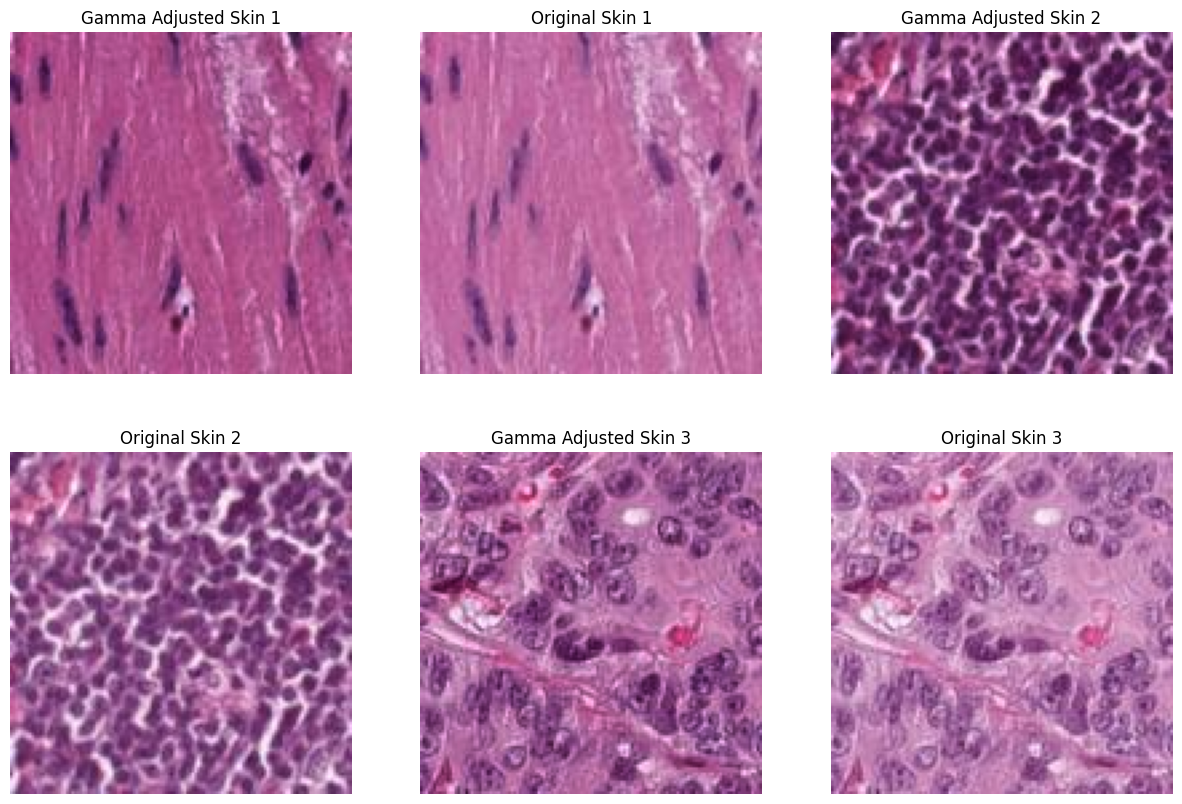

In [36]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)


image_skin1_gamma = adjust_gamma(image_skin1, 0.75)
image_skin2_gamma = adjust_gamma(image_skin2, 0.75)
image_skin3_gamma = adjust_gamma(image_skin3, 0.75)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(image_skin1_gamma, cmap='gray')
plt.title("Gamma Adjusted Skin 1")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(image_skin1, cmap='gray')
plt.title("Original Skin 1")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(image_skin2_gamma, cmap='gray')
plt.title("Gamma Adjusted Skin 2")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(image_skin2, cmap='gray')
plt.title("Original Skin 2")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(image_skin3_gamma, cmap='gray')
plt.title("Gamma Adjusted Skin 3")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(image_skin3, cmap='gray')
plt.title("Original Skin 3")
plt.axis('off')

plt.show()

Equalização de Hitograma

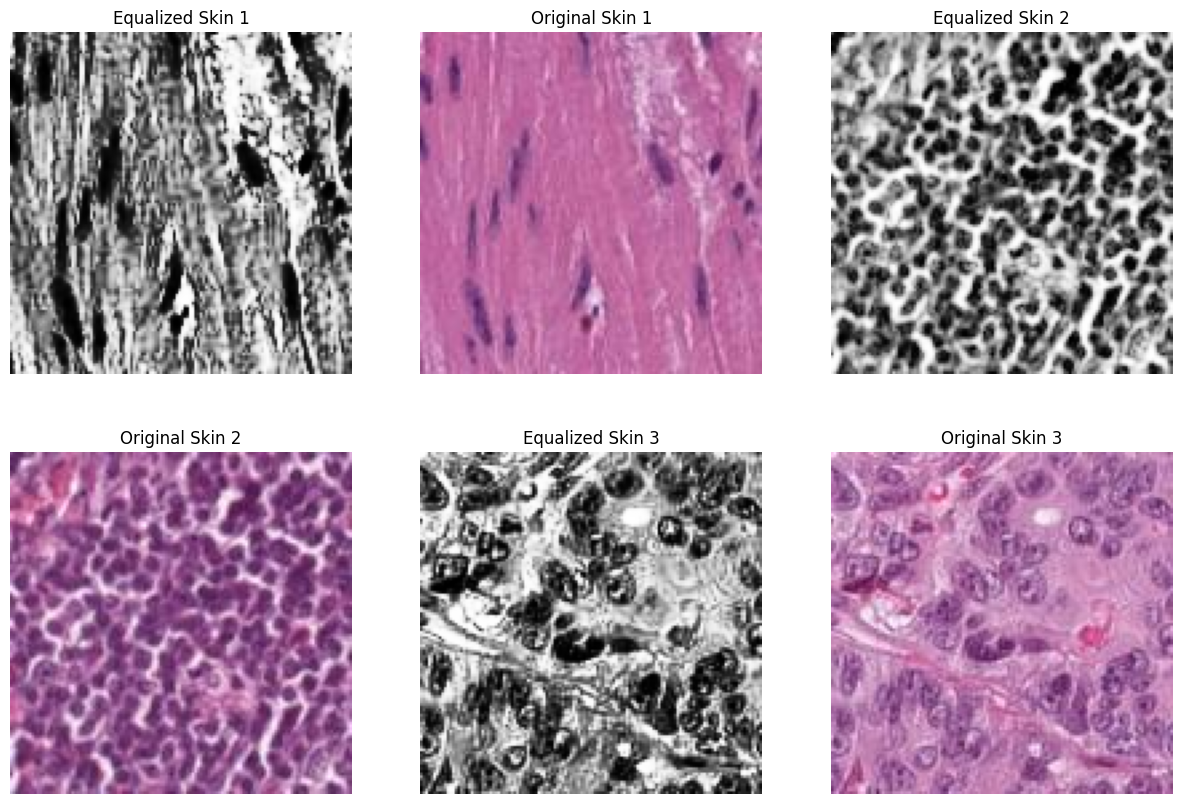

In [37]:
def histogram_equalization(image):
    height, width = image.shape

    histogram = np.zeros(256, dtype=int)
    for i in range(height):
        for j in range(width):
            intensity = image[i, j]
            histogram[intensity] += 1

    cdf = np.zeros(256, dtype=int)
    cumulative = 0
    for i in range(256):
        cumulative += histogram[i]
        cdf[i] = cumulative

    cdf_min = cdf[np.nonzero(cdf)].min()
    total_pixels = height * width
    cdf_normalized = np.round((cdf - cdf_min) / (total_pixels - cdf_min) * 255).astype('uint8')

    equalized_image = np.zeros_like(image)
    for i in range(height):
        for j in range(width):
            pixel_value = image[i, j]
            equalized_image[i, j] = cdf_normalized[pixel_value]

    return equalized_image

image_skin1_equalizated = histogram_equalization(image_skin1_pondered)
image_skin2_equalizated = histogram_equalization(image_skin2_pondered)
image_skin3_equalizated = histogram_equalization(image_skin3_pondered)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(image_skin1_equalizated, cmap='gray')
plt.title("Equalized Skin 1")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(image_skin1, cmap='gray')
plt.title("Original Skin 1")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(image_skin2_equalizated, cmap='gray')
plt.title("Equalized Skin 2")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(image_skin2, cmap='gray')
plt.title("Original Skin 2")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(image_skin3_equalizated, cmap='gray')
plt.title("Equalized Skin 3")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(image_skin3, cmap='gray')
plt.title("Original Skin 3")
plt.axis('off')

plt.show()

Aplicando ruído de sal e pimenta

In [38]:
def salt_and_pepper_noise(image, salt_prob=0.1, pepper_prob=0.1):
    noisy = image.copy()
    rnd = np.random.rand(*image.shape[:2])

    if len(image.shape) == 2:
        noisy[rnd < salt_prob] = 255
        noisy[rnd > 1 - pepper_prob] = 0
    else:
        for c in range(image.shape[2]):
            channel = noisy[:, :, c]
            channel[rnd < salt_prob] = 255
            channel[rnd > 1 - pepper_prob] = 0
            noisy[:, :, c] = channel

    return noisy

#### Fluxo do Processamento

1. **Preparação das imagens**: o Escolher duas ou três imagens do dataset indicado e preparar elas para processar. Como forma de avaliar a efetividade dos filtros, é interessante aplicar ruído como sal e pimenta e comparar a imagem original (antes de aplicar o ruído) e posterior a aplicação de filtros (na imagem com ruído).

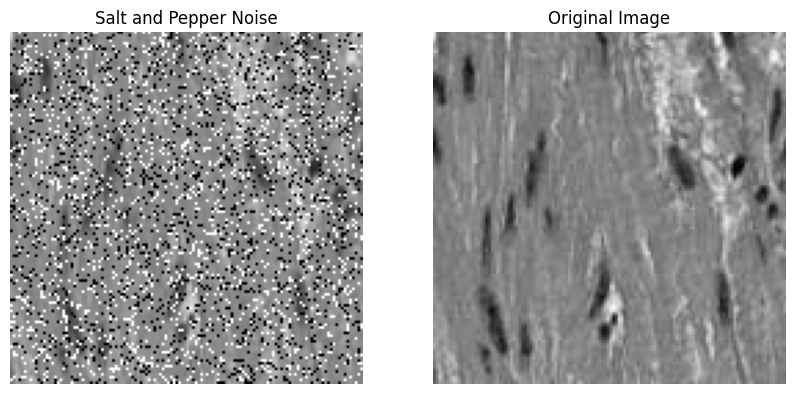

In [39]:
image_skin1_salt_and_papper = salt_and_pepper_noise(image_skin1_pondered)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_skin1_salt_and_papper, cmap='gray')
plt.title("Salt and Pepper Noise")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_skin1_pondered, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.show()

2. **Pré-processamento**: o Aplicar **equalização de histograma** e **correção gama** para melhorar o contraste.

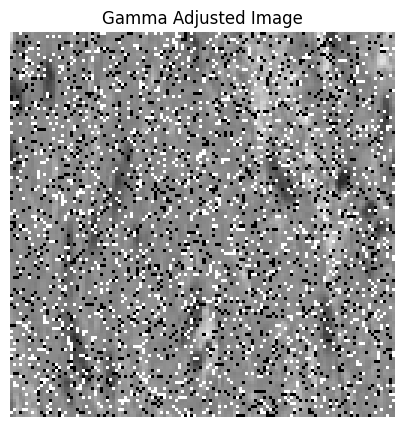

In [40]:
image_skin1_gamma = adjust_gamma(image_skin1_salt_and_papper)

plt.figure(figsize=(5, 5))

plt.imshow(image_skin1_gamma, cmap='gray')
plt.title("Gamma Adjusted Image")
plt.axis('off')

plt.show()

3. **Redução de ruído**: o Aplicar um **filtro Gaussiano** ou **mediana** para suavizar a imagem sem perder muitos detalhes.

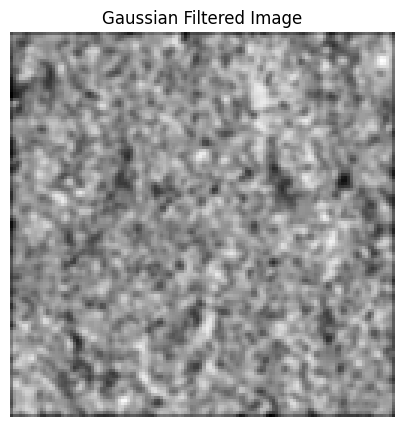

In [41]:
kernel = gaussian_kernel(size=5)
image_skin1_gaussian = gaussian(image_skin1_gamma, kernel)

plt.figure(figsize=(5, 5))

plt.imshow(image_skin1_gaussian, cmap='gray')
plt.title("Gaussian Filtered Image")
plt.axis('off')

plt.show()

4. **Realce de bordas**: o Aplicar um **filtro Laplaciano** ou **operador de Sobel** para destacar contornos importantes.

**Observação**: O Realce de bordas foi descartado do fluxo de processamento, as métricas de qualidade das imagens são piores quanto o realce de borda é aplicado.

In [40]:
# image_skin1_laplacian = laplacian(image_skin1_gaussian, laplacian_kernel)
# cv2_imshow(image_skin1_laplacian)

5. **Ajuste final (High-Boost Filtering)**: o Reforçar detalhes combinando a imagem original com a filtrada para um realce
equilibrado.

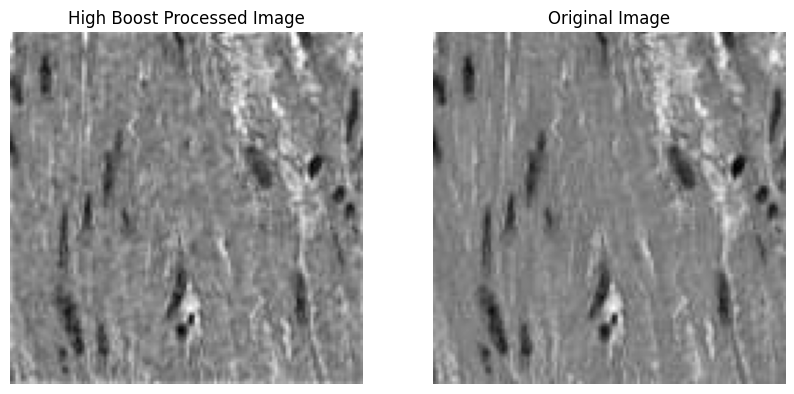

In [42]:
image_skin1_high_boost = high_boost(image_skin1_pondered, image_skin1_gaussian)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_skin1_high_boost, cmap='gray')
plt.title("High Boost Processed Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_skin1_pondered, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.show()

### Métricas de Qualidade

In [45]:
def logMetrics():
  print("MSE - Quanto mais próximo do zero, mais iguais as imagens são.")
  print("RMSE - Igual ao MSE, mas quanto maior pior.")
  print("PSNR - É a razão entre a potência máxima de um sinal e a potência máxima do sinal do ruído. Quanto maior melhor (considerável bom >= 20 dB).")
  print("SSIM - É uma métrica baseada em recurso do Sistema Visual Humano (HVS) – Hue, Saturation or Intensity Value.")
  print("     - O SSIM mede a semelhança entre duas imagens, sendo uma melhoria em relação a métodos como MSE e PSNR.")
  print("     - Basicamente, calcula a degradação da imagem para algum processo.")
  print("     - Vai de -1 a 1, sendo 1 para imagens idênticas.")
  print("GMSD - Assim como SSIM, é uma métrica para o HSV.")
  print("     - Avalia a distorção causada pelo processamento entre a imagem de referência e a imagem processada.")
  print("     - Quanto maior o valor melhor a qualidade.")

  plt.figure(figsize=(10, 10))

  plt.subplot(1, 3, 1)
  plt.imshow(image_skin1_pondered, cmap='gray')
  plt.title("Original Image (Skin 1)")
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(image_skin2_pondered, cmap='gray')
  plt.title("Original Image (Skin 2)")
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(image_skin3_pondered, cmap='gray')
  plt.title("Original Image (Skin 3)")
  plt.axis('off')

  plt.show()

MSE - Quanto mais próximo do zero, mais iguais as imagens são.
RMSE - Igual ao MSE, mas quanto maior pior.
PSNR - É a razão entre a potência máxima de um sinal e a potência máxima do sinal do ruído. Quanto maior melhor (considerável bom >= 20 dB).
SSIM - É uma métrica baseada em recurso do Sistema Visual Humano (HVS) – Hue, Saturation or Intensity Value.
     - O SSIM mede a semelhança entre duas imagens, sendo uma melhoria em relação a métodos como MSE e PSNR.
     - Basicamente, calcula a degradação da imagem para algum processo.
     - Vai de -1 a 1, sendo 1 para imagens idênticas.
GMSD - Assim como SSIM, é uma métrica para o HSV.
     - Avalia a distorção causada pelo processamento entre a imagem de referência e a imagem processada.
     - Quanto maior o valor melhor a qualidade.


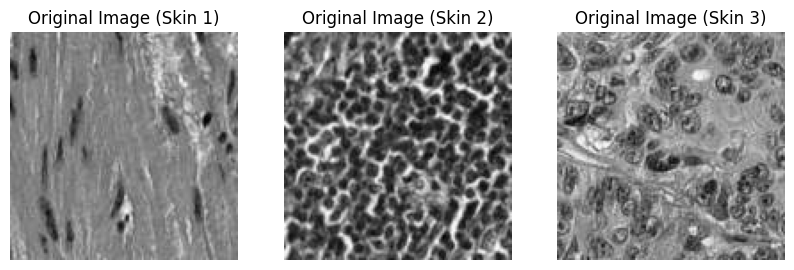


Correção Gama > Filtro Gaussiano > High-Boost Filtering:



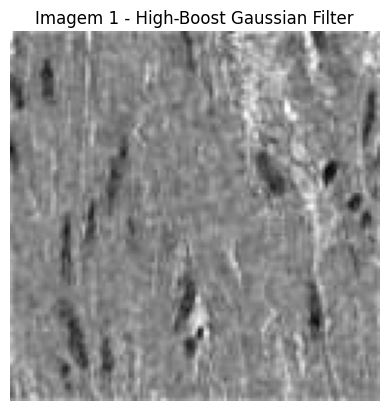

MSE: 102.56890869140625
RMSE: 10.12763095158025
PSNR: 30.632703784230273
SSIM: 0.8299477141195394
GMSD: 0.13463644145859308




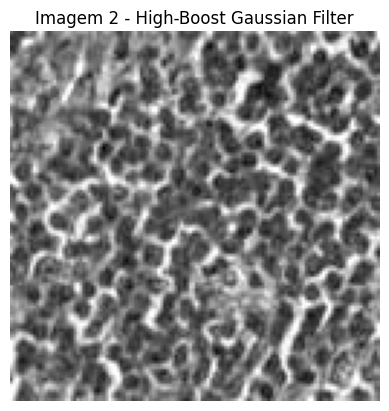

MSE: 163.2525634765625
RMSE: 12.777032655376697
PSNR: 29.752982472770327
SSIM: 0.9475642052278554
GMSD: 0.05936915829487164




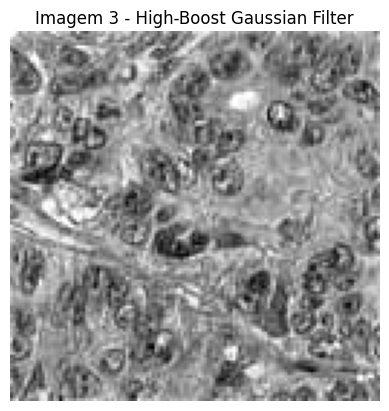

MSE: 143.02020263671875
RMSE: 11.959105427945635
PSNR: 30.12525124286909
SSIM: 0.9155913922242185
GMSD: 0.09147890786179624

Correção Gama > Filtro Mediana > High-Boost Filtering:


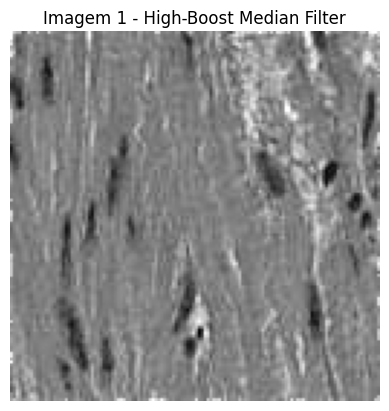

MSE: 61.5284423828125
RMSE: 7.844006781155438
PSNR: 34.49051350556416
SSIM: 0.9371260981621845
GMSD: 0.08572223133691609




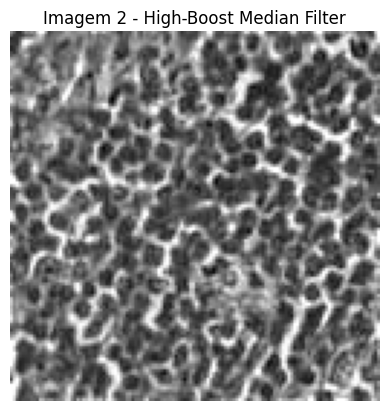

MSE: 155.89532470703125
RMSE: 12.485804928278803
PSNR: 30.52434004273177
SSIM: 0.9574418206530148
GMSD: 0.05029798559777125




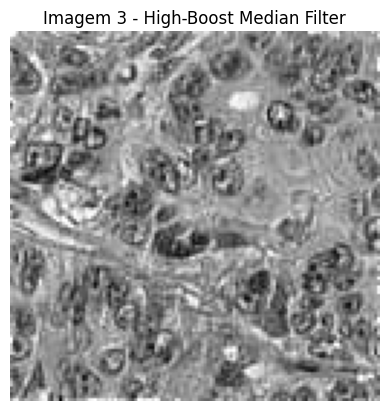

MSE: 114.84930419921875
RMSE: 10.716776763524503
PSNR: 31.222815245559833
SSIM: 0.943227515194506
GMSD: 0.054909779717728036


In [46]:
# Função para exibir as imagens em escala de cinza
def display_image(image, title=""):
    plt.imshow(image, cmap='gray')  # Exibe em escala de cinza
    plt.title(title)
    plt.axis('off')  # Não exibe o eixo
    plt.show()

image_skin1_salt_and_papper = salt_and_pepper_noise(image_skin1_pondered)
image_skin2_salt_and_papper = salt_and_pepper_noise(image_skin2_pondered)
image_skin3_salt_and_papper = salt_and_pepper_noise(image_skin3_pondered)

# Correção Gama
image_skin1_gamma = adjust_gamma(image_skin1_salt_and_papper)
image_skin2_gamma = adjust_gamma(image_skin2_salt_and_papper)
image_skin3_gamma = adjust_gamma(image_skin3_salt_and_papper)

# Correção Gama > Filtro Gaussiano
image_skin1_gamma_gaussian = gaussian(image_skin1_gamma, kernel)
image_skin2_gamma_gaussian = gaussian(image_skin2_gamma, kernel)
image_skin3_gamma_gaussian = gaussian(image_skin3_gamma, kernel)

# Correção Gama > Filtro Mediana
image_skin1_gamma_median = median(image_skin1_gamma)
image_skin2_gamma_median = median(image_skin2_gamma)
image_skin3_gamma_median = median(image_skin3_gamma)

logMetrics()

# Correção Gama > Filtro Gaussiano > High-Boost Filtering (resultado)
print("\nCorreção Gama > Filtro Gaussiano > High-Boost Filtering:\n")

image_skin1_gamma_gaussian_high_boost = high_boost(image_skin1_pondered, image_skin1_gamma_gaussian)
display_image(image_skin1_gamma_gaussian_high_boost, "Imagem 1 - High-Boost Gaussian Filter")
print("MSE:", mse(image_skin1_pondered, image_skin1_gamma_gaussian_high_boost))
print("RMSE:", rmse(image_skin1_pondered, image_skin1_gamma_gaussian_high_boost))
print("PSNR:", psnr(image_skin1_pondered, image_skin1_gamma_gaussian_high_boost))
print("SSIM:", ssim(image_skin1_pondered, image_skin1_gamma_gaussian_high_boost))
print("GMSD:", gmsd(image_skin1_pondered, image_skin1_gamma_gaussian_high_boost))

print("\n")

image_skin2_gamma_gaussian_high_boost = high_boost(image_skin2_pondered, image_skin2_gamma_gaussian)
display_image(image_skin2_gamma_gaussian_high_boost, "Imagem 2 - High-Boost Gaussian Filter")
print("MSE:", mse(image_skin2_pondered, image_skin2_gamma_gaussian_high_boost))
print("RMSE:", rmse(image_skin2_pondered, image_skin2_gamma_gaussian_high_boost))
print("PSNR:", psnr(image_skin2_pondered, image_skin2_gamma_gaussian_high_boost))
print("SSIM:", ssim(image_skin2_pondered, image_skin2_gamma_gaussian_high_boost))
print("GMSD:", gmsd(image_skin2_pondered, image_skin2_gamma_gaussian_high_boost))

print("\n")

image_skin3_gamma_gaussian_high_boost = high_boost(image_skin3_pondered, image_skin3_gamma_gaussian)
display_image(image_skin3_gamma_gaussian_high_boost, "Imagem 3 - High-Boost Gaussian Filter")
print("MSE:", mse(image_skin3_pondered, image_skin3_gamma_gaussian_high_boost))
print("RMSE:", rmse(image_skin3_pondered, image_skin3_gamma_gaussian_high_boost))
print("PSNR:", psnr(image_skin3_pondered, image_skin3_gamma_gaussian_high_boost))
print("SSIM:", ssim(image_skin3_pondered, image_skin3_gamma_gaussian_high_boost))
print("GMSD:", gmsd(image_skin3_pondered, image_skin3_gamma_gaussian_high_boost))

# Correção Gama > Filtro Mediana > High-Boost Filtering (resultado)
print("\nCorreção Gama > Filtro Mediana > High-Boost Filtering:")

image_skin1_gamma_median_high_boost = high_boost(image_skin1_pondered, image_skin1_gamma_median)
display_image(image_skin1_gamma_median_high_boost, "Imagem 1 - High-Boost Median Filter")
print("MSE:", mse(image_skin1_pondered, image_skin1_gamma_median_high_boost))
print("RMSE:", rmse(image_skin1_pondered, image_skin1_gamma_median_high_boost))
print("PSNR:", psnr(image_skin1_pondered, image_skin1_gamma_median_high_boost))
print("SSIM:", ssim(image_skin1_pondered, image_skin1_gamma_median_high_boost))
print("GMSD:", gmsd(image_skin1_pondered, image_skin1_gamma_median_high_boost))

print("\n")

image_skin2_gamma_median_high_boost = high_boost(image_skin2_pondered, image_skin2_gamma_median)
display_image(image_skin2_gamma_median_high_boost, "Imagem 2 - High-Boost Median Filter")
print("MSE:", mse(image_skin2_pondered, image_skin2_gamma_median_high_boost))
print("RMSE:", rmse(image_skin2_pondered, image_skin2_gamma_median_high_boost))
print("PSNR:", psnr(image_skin2_pondered, image_skin2_gamma_median_high_boost))
print("SSIM:", ssim(image_skin2_pondered, image_skin2_gamma_median_high_boost))
print("GMSD:", gmsd(image_skin2_pondered, image_skin2_gamma_median_high_boost))

print("\n")

image_skin3_gamma_median_high_boost = high_boost(image_skin3_pondered, image_skin3_gamma_median)
display_image(image_skin3_gamma_median_high_boost, "Imagem 3 - High-Boost Median Filter")
print("MSE:", mse(image_skin3_pondered, image_skin3_gamma_median_high_boost))
print("RMSE:", rmse(image_skin3_pondered, image_skin3_gamma_median_high_boost))
print("PSNR:", psnr(image_skin3_pondered, image_skin3_gamma_median_high_boost))
print("SSIM:", ssim(image_skin3_pondered, image_skin3_gamma_median_high_boost))
print("GMSD:", gmsd(image_skin3_pondered, image_skin3_gamma_median_high_boost))


MSE - Quanto mais próximo do zero, mais iguais as imagens são.
RMSE - Igual ao MSE, mas quanto maior pior.
PSNR - É a razão entre a potência máxima de um sinal e a potência máxima do sinal do ruído. Quanto maior melhor (considerável bom >= 20 dB).
SSIM - É uma métrica baseada em recurso do Sistema Visual Humano (HVS) – Hue, Saturation or Intensity Value.
     - O SSIM mede a semelhança entre duas imagens, sendo uma melhoria em relação a métodos como MSE e PSNR.
     - Basicamente, calcula a degradação da imagem para algum processo.
     - Vai de -1 a 1, sendo 1 para imagens idênticas.
GMSD - Assim como SSIM, é uma métrica para o HSV.
     - Avalia a distorção causada pelo processamento entre a imagem de referência e a imagem processada.
     - Quanto maior o valor melhor a qualidade.


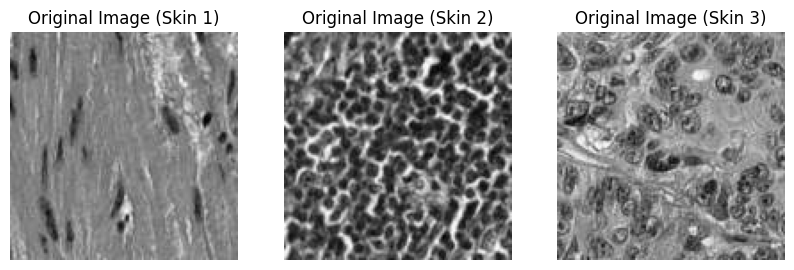


Histograma > Filtro Gaussiano > High-Boost Filtering:



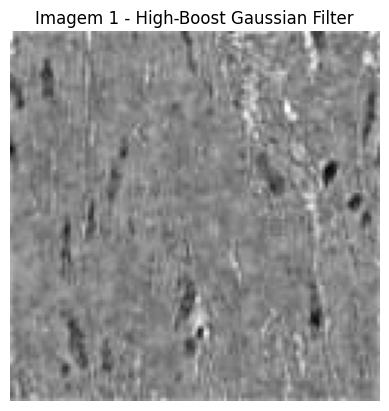

MSE: 348.41650390625
RMSE: 18.66591824438996
PSNR: 28.800317451096316
SSIM: 0.6042848623608649
GMSD: 0.15735394615706985




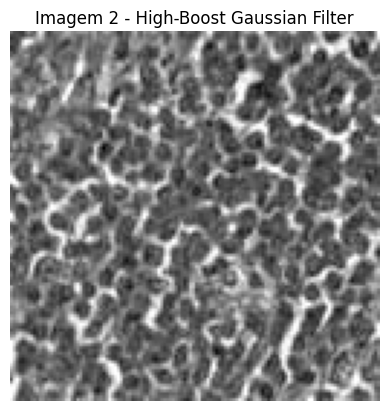

MSE: 140.68682861328125
RMSE: 11.861147862381669
PSNR: 29.779888401101992
SSIM: 0.9463736545074831
GMSD: 0.07223554894992573




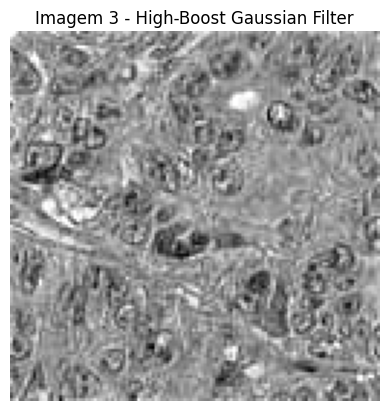

MSE: 399.36749267578125
RMSE: 19.984181060923692
PSNR: 28.60384796750083
SSIM: 0.8805010308569005
GMSD: 0.11585984139599018

Histograma > Filtro Mediana > High-Boost Filtering:


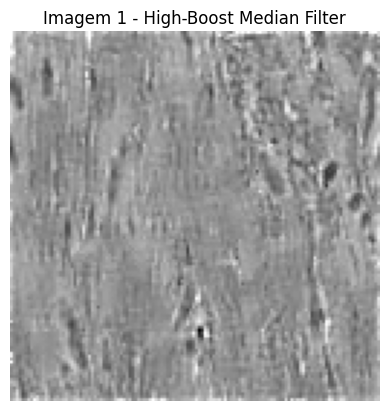

MSE: 634.4545288085938
RMSE: 25.18838082943391
PSNR: 28.395852272670133
SSIM: 0.568288100984988
GMSD: 0.1841723025730554




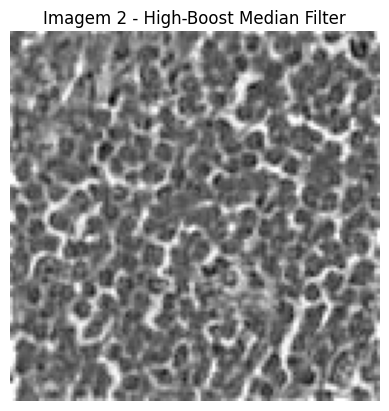

MSE: 257.83428955078125
RMSE: 16.05721923468635
PSNR: 29.093635990083172
SSIM: 0.9289499876147654
GMSD: 0.0893288079508599




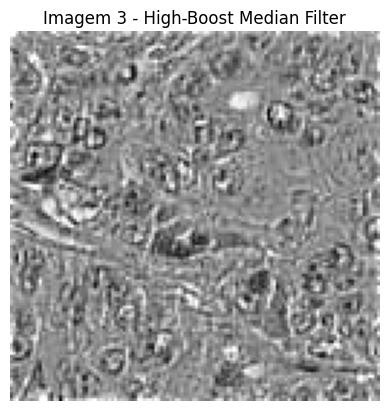

MSE: 651.4131469726562
RMSE: 25.52279661347197
PSNR: 28.44930162758324
SSIM: 0.850605755654622
GMSD: 0.13700822598104617


In [47]:
def display_image(image, title=""):
    plt.imshow(image, cmap='gray')  
    plt.title(title)
    plt.axis('off')
    plt.show()

image_skin1_histogram = histogram_equalization(image_skin1_salt_and_papper)
image_skin2_histogram = histogram_equalization(image_skin2_salt_and_papper)
image_skin3_histogram = histogram_equalization(image_skin3_salt_and_papper)

# Histograma > Filtro Gaussiano
image_skin1_histogram_gaussian = gaussian(image_skin1_histogram, kernel)
image_skin2_histogram_gaussian = gaussian(image_skin2_histogram, kernel)
image_skin3_histogram_gaussian = gaussian(image_skin3_histogram, kernel)

# Histograma > Filtro mediana
image_skin1_histogram_median = median(image_skin1_histogram)
image_skin2_histogram_median = median(image_skin2_histogram)
image_skin3_histogram_median = median(image_skin3_histogram)

logMetrics()

# Histograma > Filtro Gaussiano > High-Boost Filtering (resultado)
print("\nHistograma > Filtro Gaussiano > High-Boost Filtering:\n")

image_skin1_histogram_gaussian_high_boost = high_boost(image_skin1_pondered, image_skin1_histogram_gaussian)
display_image(image_skin1_histogram_gaussian_high_boost, "Imagem 1 - High-Boost Gaussian Filter")
print("MSE:", mse(image_skin1_pondered, image_skin1_histogram_gaussian_high_boost))
print("RMSE:", rmse(image_skin1_pondered, image_skin1_histogram_gaussian_high_boost))
print("PSNR:", psnr(image_skin1_pondered, image_skin1_histogram_gaussian_high_boost))
print("SSIM:", ssim(image_skin1_pondered, image_skin1_histogram_gaussian_high_boost))
print("GMSD:", gmsd(image_skin1_pondered, image_skin1_histogram_gaussian_high_boost))

print("\n")

image_skin2_histogram_gaussian_high_boost = high_boost(image_skin2_pondered, image_skin2_histogram_gaussian)
display_image(image_skin2_histogram_gaussian_high_boost, "Imagem 2 - High-Boost Gaussian Filter")
print("MSE:", mse(image_skin2_pondered, image_skin2_histogram_gaussian_high_boost))
print("RMSE:", rmse(image_skin2_pondered, image_skin2_histogram_gaussian_high_boost))
print("PSNR:", psnr(image_skin2_pondered, image_skin2_histogram_gaussian_high_boost))
print("SSIM:", ssim(image_skin2_pondered, image_skin2_histogram_gaussian_high_boost))
print("GMSD:", gmsd(image_skin2_pondered, image_skin2_histogram_gaussian_high_boost))

print("\n")

image_skin3_histogram_gaussian_high_boost = high_boost(image_skin3_pondered, image_skin3_histogram_gaussian)
display_image(image_skin3_histogram_gaussian_high_boost, "Imagem 3 - High-Boost Gaussian Filter")
print("MSE:", mse(image_skin3_pondered, image_skin3_histogram_gaussian_high_boost))
print("RMSE:", rmse(image_skin3_pondered, image_skin3_histogram_gaussian_high_boost))
print("PSNR:", psnr(image_skin3_pondered, image_skin3_histogram_gaussian_high_boost))
print("SSIM:", ssim(image_skin3_pondered, image_skin3_histogram_gaussian_high_boost))
print("GMSD:", gmsd(image_skin3_pondered, image_skin3_histogram_gaussian_high_boost))

# Histograma > Filtro Mediana > High-Boost Filtering (resultado)
print("\nHistograma > Filtro Mediana > High-Boost Filtering:")

image_skin1_histogram_median_high_boost = high_boost(image_skin1_pondered, image_skin1_histogram_median)
display_image(image_skin1_histogram_median_high_boost, "Imagem 1 - High-Boost Median Filter")
print("MSE:", mse(image_skin1_pondered, image_skin1_histogram_median_high_boost))
print("RMSE:", rmse(image_skin1_pondered, image_skin1_histogram_median_high_boost))
print("PSNR:", psnr(image_skin1_pondered, image_skin1_histogram_median_high_boost))
print("SSIM:", ssim(image_skin1_pondered, image_skin1_histogram_median_high_boost))
print("GMSD:", gmsd(image_skin1_pondered, image_skin1_histogram_median_high_boost))

print("\n")

image_skin2_histogram_median_high_boost = high_boost(image_skin2_pondered, image_skin2_histogram_median)
display_image(image_skin2_histogram_median_high_boost, "Imagem 2 - High-Boost Median Filter")
print("MSE:", mse(image_skin2_pondered, image_skin2_histogram_median_high_boost))
print("RMSE:", rmse(image_skin2_pondered, image_skin2_histogram_median_high_boost))
print("PSNR:", psnr(image_skin2_pondered, image_skin2_histogram_median_high_boost))
print("SSIM:", ssim(image_skin2_pondered, image_skin2_histogram_median_high_boost))
print("GMSD:", gmsd(image_skin2_pondered, image_skin2_histogram_median_high_boost))

print("\n")

image_skin3_histogram_median_high_boost = high_boost(image_skin3_pondered, image_skin3_histogram_median)
display_image(image_skin3_histogram_median_high_boost, "Imagem 3 - High-Boost Median Filter")
print("MSE:", mse(image_skin3_pondered, image_skin3_histogram_median_high_boost))
print("RMSE:", rmse(image_skin3_pondered, image_skin3_histogram_median_high_boost))
print("PSNR:", psnr(image_skin3_pondered, image_skin3_histogram_median_high_boost))
print("SSIM:", ssim(image_skin3_pondered, image_skin3_histogram_median_high_boost))
print("GMSD:", gmsd(image_skin3_pondered, image_skin3_histogram_median_high_boost))
